# Galaxy Classification, Anomaly Detection, Autoencoder & VAE (Keras)
This notebook uses the Galaxy10 DECaLS dataset (astronomical galaxy images) for:

1. Data loading & splitting, defining an anomaly class  
2. CNN classifier + ROC curves & confusion matrices  
3. Convolutional autoencoder for anomaly detection  
4. Variational autoencoder (VAE) + galaxy generation

Dataset: Galaxy10 DECaLS (HDF5).

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf

print("Physical devices:", tf.config.list_physical_devices())
print("Logical GPU devices:", tf.config.list_logical_devices('GPU'))
print("GPU device name:", tf.test.gpu_device_name())

from tensorflow import keras # (changed) sticking to tf.keras
from tensorflow.keras import layers, ops, Model, random

import numpy as np
import h5py
import matplotlib.pyplot as plt
import random as py_random

SEED = 42  # for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)
py_random.seed(SEED)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Logical GPU devices: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU device name: /device:GPU:0


## 1. Download the dataset, inspect classes, create anomaly split

Steps:
- Download `Galaxy10_DECals_64.h5`
- Load images and labels with `h5py`
- Inspect shape and class distribution
- Remove class 0 and store it as the anomaly dataset
- Split remaining (standard) data into train (50%), val (25%), test (25%)

In [2]:
# Download Galaxy10 DECaLS (HDF5)
! rm ./Galaxy10_DECals_64.h5
! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
data_path = "./Galaxy10_DECals_64.h5"

print("Downloaded to:", data_path)

--2025-12-08 20:26:16--  https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.35, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159140118 (152M) [application/octet-stream]
Saving to: ‘Galaxy10_DECals_64.h5’

Galaxy10_DECals_64. 100%[===================>] 151.77M  19.7MB/s    in 8.8s    

2025-12-08 20:26:26 (17.3 MB/s) - ‘Galaxy10_DECals_64.h5’ saved [159140118/159140118]

Downloaded to: ./Galaxy10_DECals_64.h5


In [3]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 64, 64, 3) (changed from 256 to 64)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
images = images.astype("float32") / 255.0 # (Keras works more efficiently and uses less memory with float32)


print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)


Images shape: (17736, 64, 64, 3)
Labels shape: (17736,) dtype: uint8


In [4]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

Class distribution:
Class 0 (Disturbed Galaxies): 1081
Class 1 (Merging Galaxies): 1853
Class 2 (Round Smooth Galaxies): 2645
Class 3 (In-between Round Smooth Galaxies): 2027
Class 4 (Cigar Shaped Smooth Galaxies): 334
Class 5 (Barred Spiral Galaxies): 2043
Class 6 (Unbarred Tight Spiral Galaxies): 1829
Class 7 (Unbarred Loose Spiral Galaxies): 2628
Class 8 (Edge-on Galaxies without Bulge): 1423
Class 9 (Edge-on Galaxies with Bulge): 1873


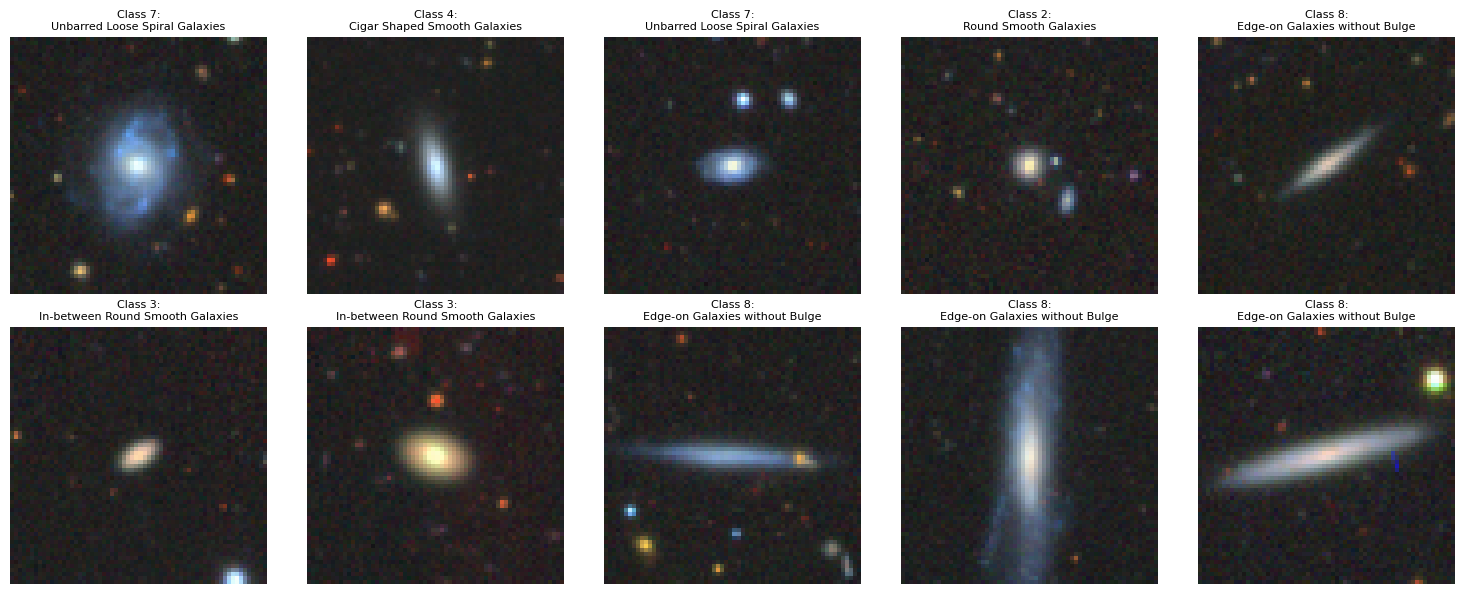

In [5]:
# Show a grid of sample images from different classes
def show_examples(images, labels, class_names, n_rows=2, n_cols=5):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [6]:
# Create anomaly dataset: all class 0 images (changed to 4 for now)
ANOMALY_CLASS = 4

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 0, but we keep them for bookkeeping (changed to 4)

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

Standard images: (17402, 64, 64, 3)
Anomaly images: (334, 64, 64, 3)


In [7]:
# For training, remap standard labels from {0,1,2,3,5,6,7,8,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

Standard classes (original indices): [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]
Label map (original -> new): {np.uint8(0): 0, np.uint8(1): 1, np.uint8(2): 2, np.uint8(3): 3, np.uint8(5): 4, np.uint8(6): 5, np.uint8(7): 6, np.uint8(8): 7, np.uint8(9): 8}
Remapped standard labels min/max: 0 8


In [8]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del std_images, std_labels, X_temp_std, y_temp_std

Train standard: (8701, 64, 64, 3) (8701,)
Val standard:   (4350, 64, 64, 3) (4350,)
Test standard:  (4351, 64, 64, 3) (4351,)


**EDA**

In [9]:
with h5py.File(data_path, "r") as f:
    images = f["images"][()]      # (N, 64, 64, 3)
    labels = f["ans"][()]         # (N,)
    ra = f["ra"][()]
    dec = f["dec"][()]
    redshift = f["redshift"][()]
    pxscale = f["pxscale"][()]

Dataset structure & basic stats

In [10]:
# Basic dataset overview
N, H, W, C = images.shape
print(f"Number of images: {N}")
print(f"Image size: {H}x{W}, channels: {C}")
print(f"Images dtype: {images.dtype}, range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Labels shape: {labels.shape}, dtype: {labels.dtype}")

# Per-channel statistics
channel_means = images.reshape(-1, C).mean(axis=0)
channel_stds = images.reshape(-1, C).std(axis=0)
print("\nPer-channel mean (R,G,B):", channel_means)
print("Per-channel std  (R,G,B):", channel_stds)

# Check metadata arrays
print("\nRA shape:", ra.shape, "Dec shape:", dec.shape)
print("Redshift shape:", redshift.shape, "Pxscale shape:", pxscale.shape)

# Redshift NaN info
nan_z = np.isnan(redshift).sum()
print(f"\nRedshift NaNs: {nan_z} / {N}")


Number of images: 17736
Image size: 64x64, channels: 3
Images dtype: uint8, range: [0.000, 255.000]
Labels shape: (17736,), dtype: uint8

Per-channel mean (R,G,B): [42.70681794 41.46586604 40.5271324 ]
Per-channel std  (R,G,B): [29.11579624 27.62588207 25.58566254]

RA shape: (17736,) Dec shape: (17736,)
Redshift shape: (17736,) Pxscale shape: (17736,)

Redshift NaNs: 92 / 17736


Class distribution

=== Class distribution ===
Class 0 (Disturbed Galaxies): 1081 samples (6.09%)
Class 1 (Merging Galaxies): 1853 samples (10.45%)
Class 2 (Round Smooth Galaxies): 2645 samples (14.91%)
Class 3 (In-between Round Smooth Galaxies): 2027 samples (11.43%)
Class 4 (Cigar Shaped Smooth Galaxies): 334 samples (1.88%)
Class 5 (Barred Spiral Galaxies): 2043 samples (11.52%)
Class 6 (Unbarred Tight Spiral Galaxies): 1829 samples (10.31%)
Class 7 (Unbarred Loose Spiral Galaxies): 2628 samples (14.82%)
Class 8 (Edge-on Galaxies without Bulge): 1423 samples (8.02%)
Class 9 (Edge-on Galaxies with Bulge): 1873 samples (10.56%)


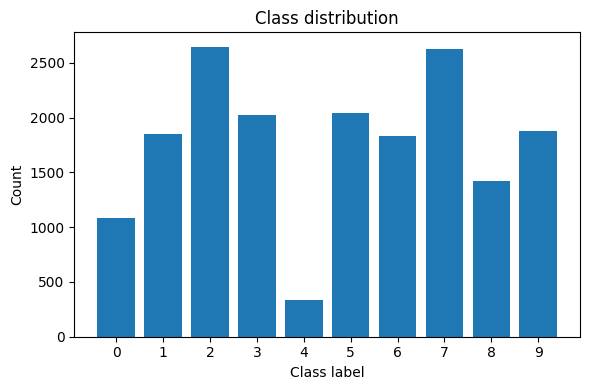

In [11]:
# Class names
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # anomaly for me
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)

print("=== Class distribution ===")
for u, c in zip(unique, counts):
    frac = c / N * 100
    print(f"Class {u} ({class_names[u]}): {c} samples ({frac:.2f}%)")

# Bar plot
plt.figure(figsize=(6,4))
plt.bar(unique, counts)
plt.xticks(unique)
plt.xlabel("Class label")
plt.ylabel("Count")
plt.title("Class distribution")
plt.tight_layout()
plt.show()


Examples per class

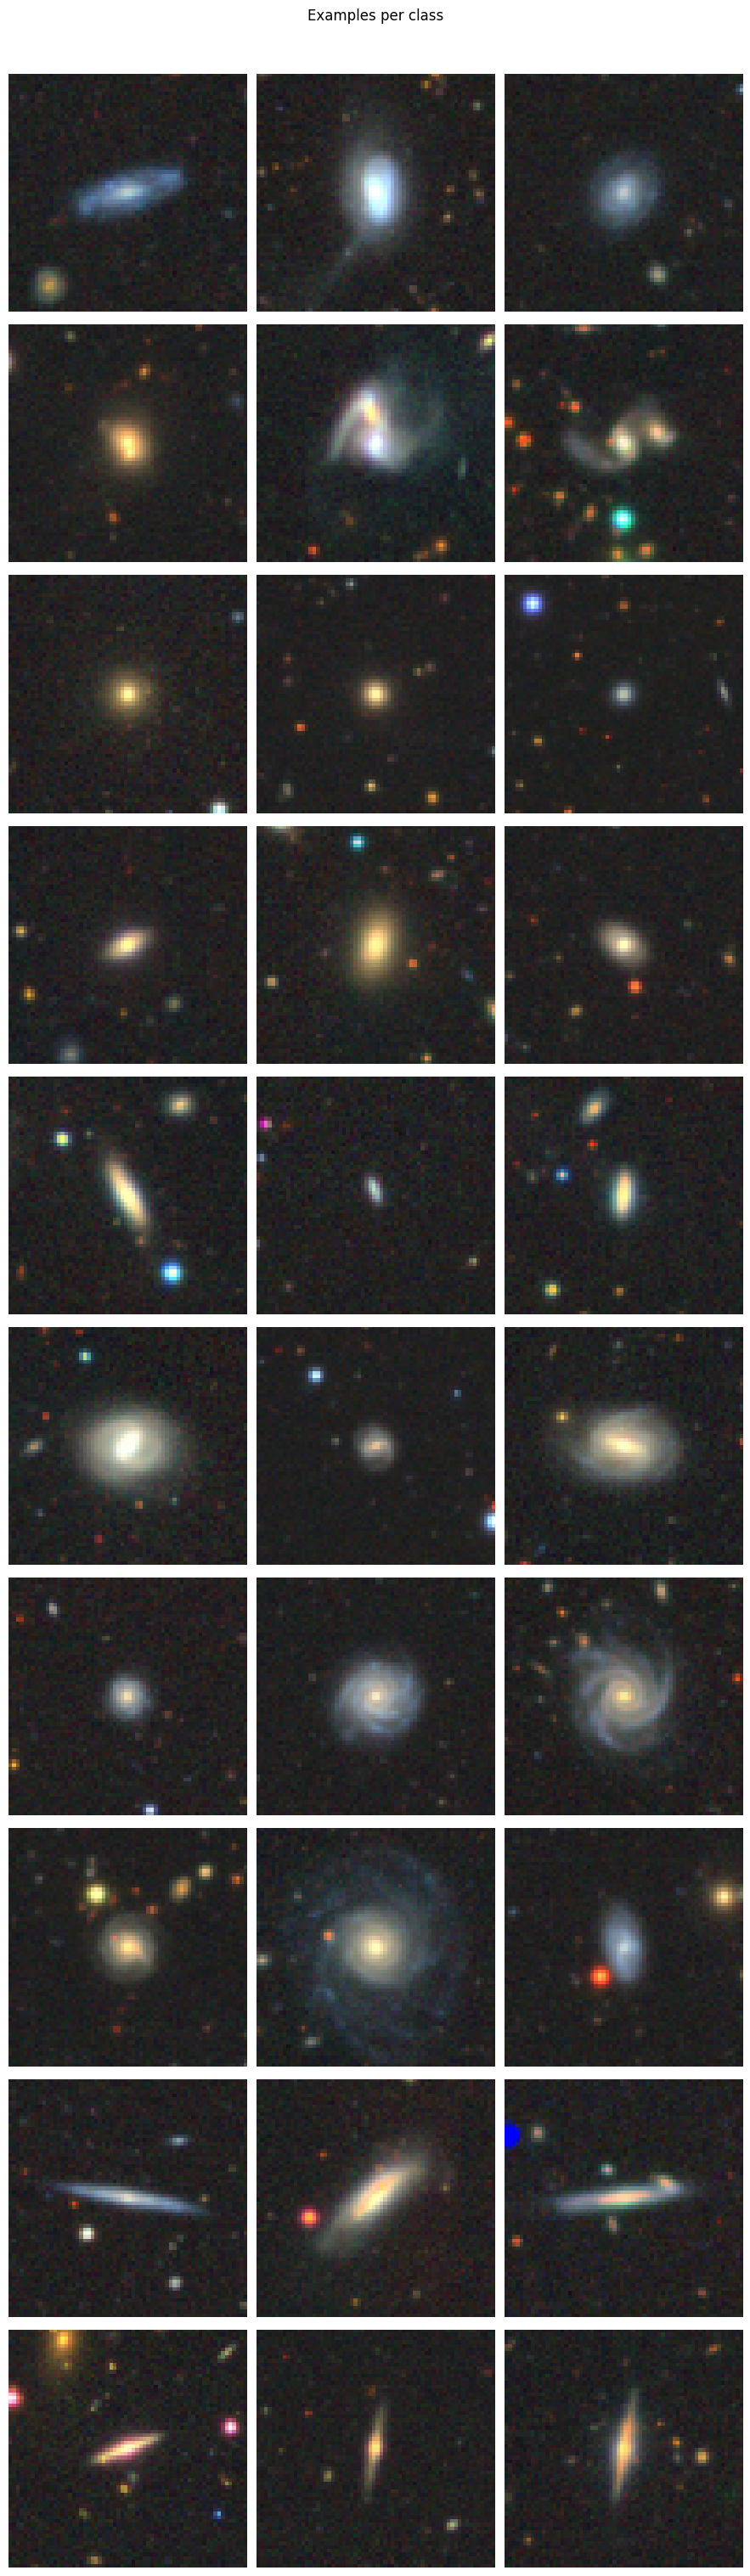

In [12]:
# Show a few examples per class
examples_per_class = 3
classes = np.unique(labels)

plt.figure(figsize=(examples_per_class * 3, len(classes) * 3))

for row, c in enumerate(classes):
    idxs = np.where(labels == c)[0]
    n_show = min(examples_per_class, len(idxs))
    chosen = np.random.choice(idxs, size=n_show, replace=False)

    for col, idx in enumerate(chosen):
        ax = plt.subplot(len(classes), examples_per_class, row * examples_per_class + col + 1)
        ax.imshow(images[idx])
        if col == 0:
            ax.set_ylabel(f"{c}: {class_names[c]}", fontsize=8)
        ax.axis("off")

plt.suptitle("Examples per class", y=1.01)
plt.tight_layout()
plt.show()


Metadata distributions

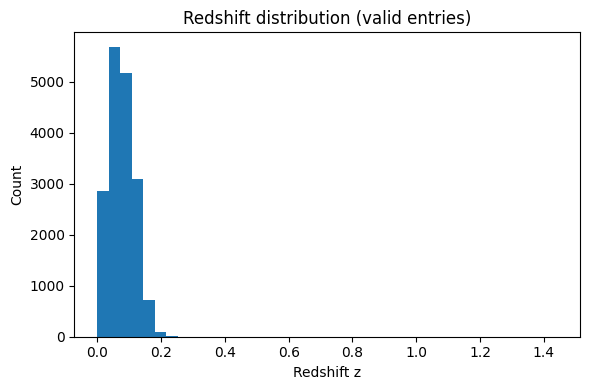

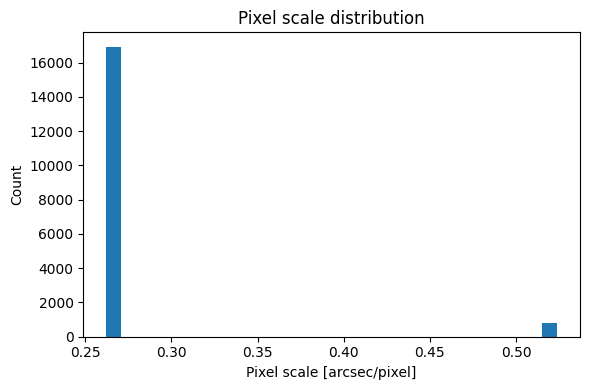

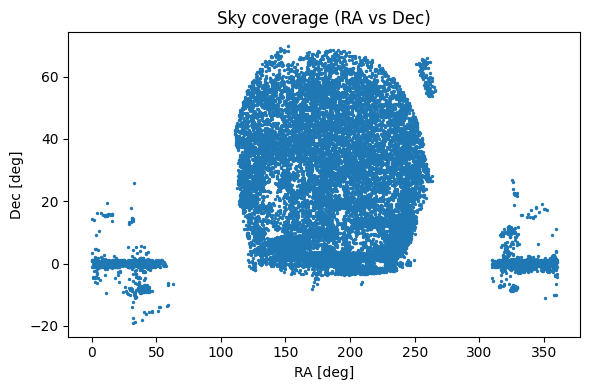

In [13]:
# Redshift distribution (valid values only)
valid_z = redshift[~np.isnan(redshift)]

plt.figure(figsize=(6,4))
plt.hist(valid_z, bins=40)
plt.xlabel("Redshift z")
plt.ylabel("Count")
plt.title("Redshift distribution (valid entries)")
plt.tight_layout()
plt.show()

# Pixel scale distribution
plt.figure(figsize=(6,4))
plt.hist(pxscale, bins=30)
plt.xlabel("Pixel scale [arcsec/pixel]")
plt.ylabel("Count")
plt.title("Pixel scale distribution")
plt.tight_layout()
plt.show()

# Sky coverage
plt.figure(figsize=(6,4))
plt.scatter(ra, dec, s=2)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("Sky coverage (RA vs Dec)")
plt.tight_layout()
plt.show()


## 2. CNN classifier + ROC curves + confusion matrices

Steps:
- Build a CNN classifier on the **standard** dataset (9 classes)
- Train on train set, validate on val set
- Plot training history (loss & accuracy)
- Compute ROC curves (one-vs-rest) on the standard test set
- Compute confusion matrix for standard test

Build a CNN classifier on the standard dataset (9 classes)

In [14]:
# Simple, fast CNN for 64x64x3 images, 9 classes
def build_simple_cnn(input_shape, n_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)          # 32x32

    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)          # 16x16

    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)          # 8x8

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


input_shape = X_train_std.shape[1:]  # (64, 64, 3)
model = build_simple_cnn(input_shape, n_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,409 (368.79 KB)

 Trainable params: 94,409 (368.79 KB)

 Non-trainable params: 0 (0.00 B)

Train on train set, validate on val set

In [15]:
# Train the CNN
batch_size = 64
epochs = 20

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True,
    )
]

history = model.fit(
    X_train_std, y_train_std,
    validation_data=(X_val_std, y_val_std),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.1597 - loss: 2.1766 - val_accuracy: 0.1510 - val_loss: 2.1621
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1787 - loss: 2.1378 - val_accuracy: 0.2437 - val_loss: 1.9973
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2371 - loss: 2.0006 - val_accuracy: 0.2600 - val_loss: 1.9304
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2600 - loss: 1.9518 - val_accuracy: 0.2772 - val_loss: 1.8928
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2705 - loss: 1.9245 - val_accuracy: 0.2984 - val_loss: 1.8636
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2878 - loss: 1.8913 - val_accuracy: 0.3246 - val_loss: 1.8165
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3186 - loss: 1.8456 - val_accuracy: 0.3853 - val_loss: 1.7470
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3529 - loss: 1.7822 - val_acc

Plot training history (loss & accuracy)

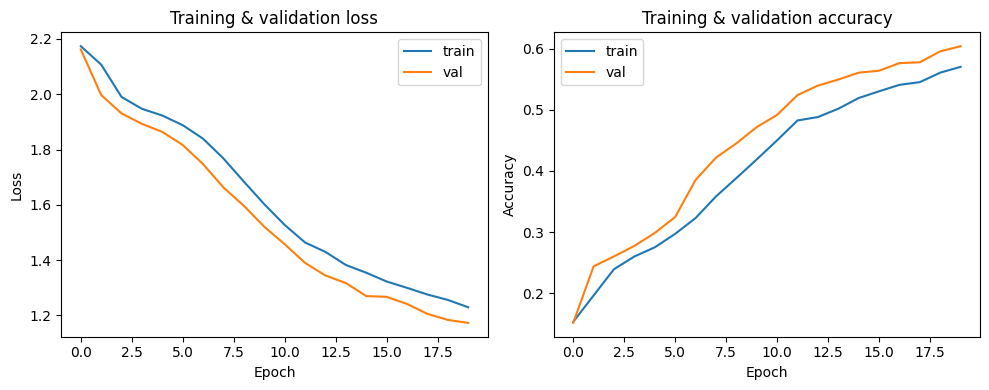

In [16]:
# Plot training history: loss & accuracy
history_dict = history.history

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_dict["loss"], label="train")
plt.plot(history_dict["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_dict["accuracy"], label="train")
plt.plot(history_dict["val_accuracy"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & validation accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Predictions on the standard test set

In [17]:
y_proba_test = model.predict(X_test_std)
y_pred_test = np.argmax(y_proba_test, axis=1)

print("Test accuracy (overall):", np.mean(y_pred_test == y_test_std))

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test accuracy (overall): 0.5890599862100666


Per-class and overall accuracy, sensitivity, specificity

In [18]:
def per_class_metrics(y_true, y_pred, class_names, inv_label_map):
    classes = np.unique(y_true)
    metrics = []

    for c in classes:
        # one-vs-rest for class c
        tp = np.sum((y_true == c) & (y_pred == c))
        tn = np.sum((y_true != c) & (y_pred != c))
        fp = np.sum((y_true != c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))

        total = tp + tn + fp + fn

        acc = (tp + tn) / total if total > 0 else np.nan
        sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan  # recall
        spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan

        original_label = inv_label_map[int(c)]
        name = class_names[original_label]

        metrics.append({
            "mapped_class": int(c),
            "original_class": int(original_label),
            "name": name,
            "TP": int(tp),
            "TN": int(tn),
            "FP": int(fp),
            "FN": int(fn),
            "accuracy": acc,
            "sensitivity": sens,
            "specificity": spec,
        })

    return metrics


metrics_per_class = per_class_metrics(
    y_test_std, y_pred_test, class_names=class_names, inv_label_map=inv_label_map
)

for m in metrics_per_class:
    print(
        f"Class {m['original_class']} ({m['name']}) "
        f"=> acc={m['accuracy']:.3f}, sens={m['sensitivity']:.3f}, spec={m['specificity']:.3f}"
    )

Class 0 (Disturbed Galaxies) => acc=0.939, sens=0.033, spec=0.999
Class 1 (Merging Galaxies) => acc=0.899, sens=0.503, spec=0.947
Class 2 (Round Smooth Galaxies) => acc=0.929, sens=0.834, spec=0.946
Class 3 (In-between Round Smooth Galaxies) => acc=0.924, sens=0.700, spec=0.954
Class 5 (Barred Spiral Galaxies) => acc=0.879, sens=0.311, spec=0.955
Class 6 (Unbarred Tight Spiral Galaxies) => acc=0.903, sens=0.510, spec=0.950
Class 7 (Unbarred Loose Spiral Galaxies) => acc=0.812, sens=0.619, spec=0.847
Class 8 (Edge-on Galaxies without Bulge) => acc=0.954, sens=0.744, spec=0.972
Class 9 (Edge-on Galaxies with Bulge) => acc=0.938, sens=0.748, spec=0.961


In [19]:
tp_total = sum(m["TP"] for m in metrics_per_class)
tn_total = sum(m["TN"] for m in metrics_per_class)
fp_total = sum(m["FP"] for m in metrics_per_class)
fn_total = sum(m["FN"] for m in metrics_per_class)
total = tp_total + tn_total + fp_total + fn_total

overall_acc  = (tp_total + tn_total) / total
overall_sens = tp_total / (tp_total + fn_total)
overall_spec = tn_total / (tn_total + fp_total)

print("\nOverall (micro-averaged across classes):")
print(f"Accuracy   : {overall_acc:.3f}")
print(f"Sensitivity: {overall_sens:.3f}")
print(f"Specificity: {overall_spec:.3f}")



Overall (micro-averaged across classes):
Accuracy   : 0.909
Sensitivity: 0.589
Specificity: 0.949


Compute ROC curves (one-vs-rest) on the standard test set

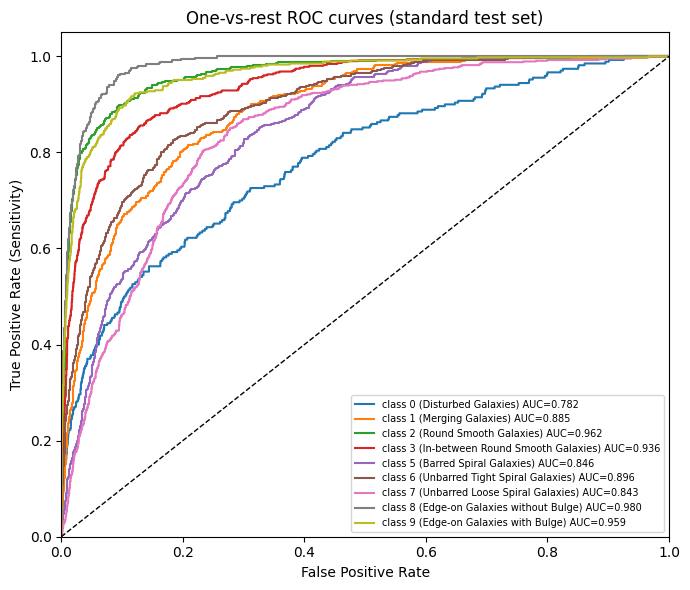

In [20]:
classes = np.unique(y_test_std)
plt.figure(figsize=(7,6))

for c in classes:
    # binary labels: 1 if this class, 0 otherwise
    y_true_c = (y_test_std == c).astype(int)
    y_score_c = y_proba_test[:, c]

    fpr, tpr, _ = roc_curve(y_true_c, y_score_c)
    roc_auc = auc(fpr, tpr)

    original_label = inv_label_map[int(c)]
    label_name = class_names[original_label]
    plt.plot(fpr, tpr, lw=1.5, label=f"class {original_label} ({label_name}) AUC={roc_auc:.3f}")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("One-vs-rest ROC curves (standard test set)")
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()


Compute confusion matrix for standard test

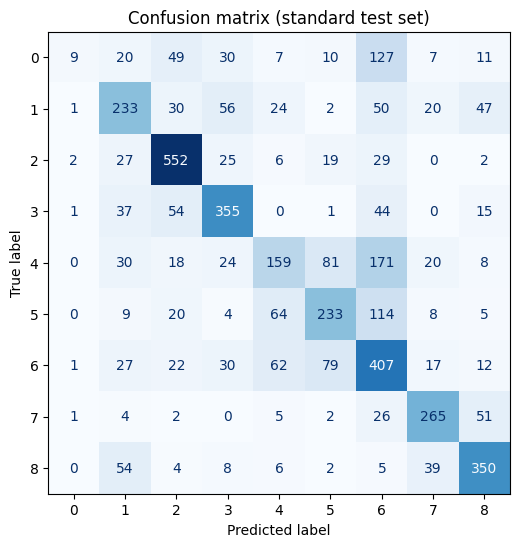

In [21]:
cm = confusion_matrix(y_test_std, y_pred_test)

fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion matrix (standard test set)")
plt.show()


## 3. Convolutional Autoencoder for anomaly detection

Steps:
- Train a convolutional autoencoder on **standard** train set only
- Plot training history
- Compute reconstruction loss (MSE) per image for:
  - Standard test set
  - Anomaly dataset (class 4)
- Plot histograms of reconstruction losses
- Use reconstruction loss as anomaly score and build ROC curve & confusion matrix (adapt provided code)

## 4. Variational Autoencoder (VAE) on standard data

Steps:
- Build a VAE with convolutional encoder/decoder (trained on standard train set)
- Plot training history
- Generate new galaxy images from the VAE
- Visualize some generated images